<a href="https://colab.research.google.com/github/MarinaChau/AttaCoeurs/blob/main/Attack_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('myDrive')

Mounted at myDrive


In [3]:
!git clone https://github.com/MarinaChau/AttaCoeurs.git

Cloning into 'AttaCoeurs'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 68 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.


# Project Adversarial Attack

In [4]:
%cd AttaCoeurs

/content/AttaCoeurs


In [5]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from AttaCoeurs.src import adversarial_attacks as attacks
from AttaCoeurs.src import custom_model as models



## 1.1 Code `∞-PGD attack & Observe robustness of neural networks


### STEP 1: Load Cifar10 Dataset

In [6]:
# Load Cifar dataset from keras
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(50000,32, 32,3).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 32, 32, 3).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### STEP 2 Build a simpler Classifier

In [7]:
# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [32, 32, 3]
        self.num_classes = 10
        self.num_conv_filters = [64, 64, 32, 32]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [512]
        
cnn_params = CnnParams()


def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    #x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    
    # Convolutional layer followed by 
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, cnn_params.kernel_size, padding='same', activation='relu')(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # max pooling between convolutional layers + dropout
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size)(x)
            x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)

    for num_units in cnn_params.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                              adv_training_with=adv_training_with)



def build_model(batch_size, num_classes, epochs, learning_rate=0.0001, decay=1e-06):

    inputs = tf.keras.Input(shape=x_train.shape[1:])
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifar_classifier")
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()

    return model

In [8]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = [tf.keras.metrics.SparseCategoricalAccuracy]
OPTIMIZER = tf.keras.optimizers.RMSprop()

In [9]:
model = get_cnn_model()
model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [10]:
# Compile Model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS, metrics=["accuracy"])
# Train Model 
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=40, validation_split=0.2)

# Evaluate Model
print("\n")
evaluation = model.evaluate(x_test,y_test, verbose=2)

Epoch 1/40
1250/1250 [==============================] - 16s 5ms/step - loss: 1.6887 - accuracy: 0.3841 - val_loss: 1.4060 - val_accuracy: 0.4958
Epoch 2/40
1250/1250 [==============================] - 6s 4ms/step - loss: 1.3512 - accuracy: 0.5139 - val_loss: 1.3169 - val_accuracy: 0.5327
Epoch 3/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2262 - accuracy: 0.5629 - val_loss: 1.2458 - val_accuracy: 0.5615
Epoch 4/40
1250/1250 [==============================] - 6s 4ms/step - loss: 1.1512 - accuracy: 0.5910 - val_loss: 1.0013 - val_accuracy: 0.6472
Epoch 5/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1157 - accuracy: 0.6083 - val_loss: 1.1016 - val_accuracy: 0.6166
Epoch 6/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0874 - accuracy: 0.6216 - val_loss: 1.0056 - val_accuracy: 0.6459
Epoch 7/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0742 - accuracy: 0.6252 - val_loss: 1.0169 - val_accuracy

In [11]:
evaluation = model.evaluate(x_test,y_test, verbose=2)

313/313 - 1s - loss: 0.9950 - accuracy: 0.6536 - 683ms/epoch - 2ms/step


### STEP 3 PGD L-Inf on our model

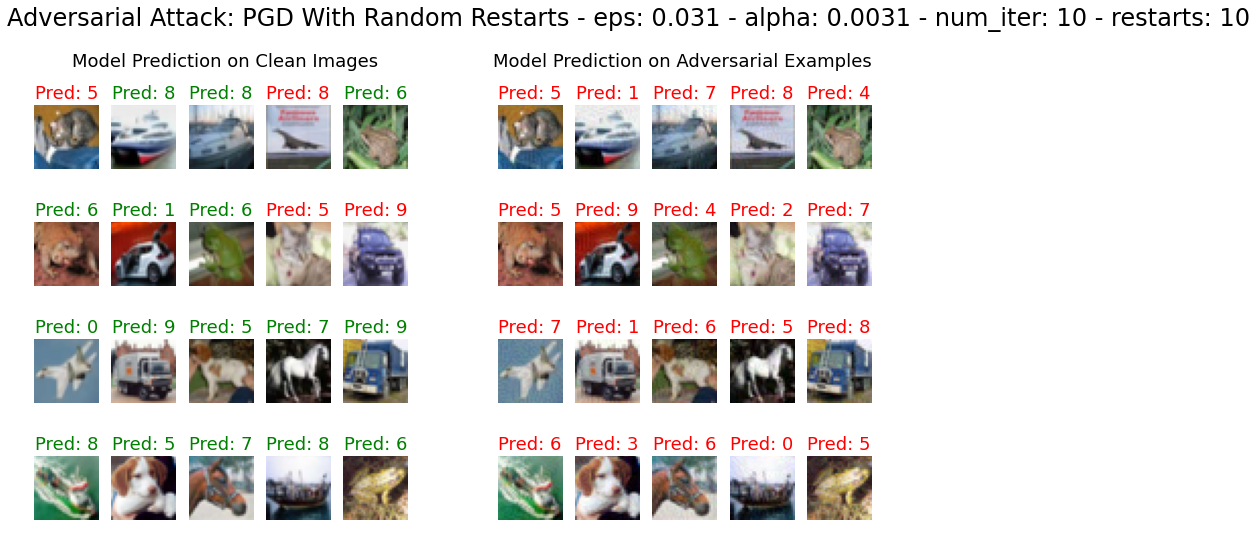

In [12]:
# Attack to be tested
Attack = attacks.PgdRandomRestart
# Attack parameters
eps = 0.031
num_iter = 10
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}


attacks.attack_visual_demo(model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

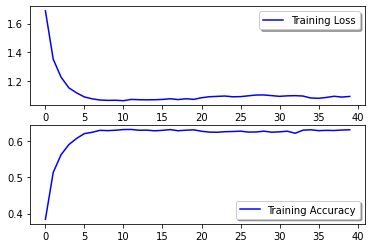

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
!pwd

/content/AttaCoeurs


In [14]:
# save model
import os
# model_save_path = "/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5"
model_save_path = "../model.h5"
print(os.path.exists(model_save_path))
model.save(model_save_path)

False


#### Load the module



In [15]:
import os
print(os.path.exists("/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5"))
model = tf.keras.models.load_model("/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5")

False


OSError: ignored

#### Evaluate the model on Cifar10 with different epsilon values

In [16]:
# Small script to generate adversed images

# Set the parameters
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}

# Instanciate the attack class
pgd_linf = Attack(model=model, **attack_kwargs)

# Create attack images
x_test_adv = pgd_linf(x_test, y_test)

evaluation = model.evaluate(x_test_adv,y_test, verbose=2)

313/313 - 1s - loss: 9.0921 - accuracy: 0.0057 - 632ms/epoch - 2ms/step


## 1.2 Code Adversarial training & Observe robustness of neural networks

In [ ]:
# Set adversarial training parameters
eps = 0.031
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}
adv_training_with = {"attack": attacks.PgdRandomRestart,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

# Train model
cnn_model_pgd.fit(x_train, y_train,
                   batch_size=32,epochs=20,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_pgd.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_pgd.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/20
1250/1250 [==============================] - 503s 401ms/step - loss: 1.9326 - accuracy: 0.2887 - val_loss: 1.5613 - val_accuracy: 0.4402
Epoch 2/20
1250/1250 [==============================] - 497s 398ms/step - loss: 1.7047 - accuracy: 0.3785 - val_loss: 1.4389 - val_accuracy: 0.5070
Epoch 3/20
1250/1250 [==============================] - 496s 397ms/step - loss: 1.6286 - accuracy: 0.4103 - val_loss: 1.3226 - val_accuracy: 0.5411
Epoch 4/20
1250/1250 [==============================] - 496s 396ms/step - loss: 1.5900 - accuracy: 0.4275 - val_loss: 1.3266 - val_accuracy: 0.5415
Epoch 5/20
1250/1250 [==============================] - 495s 396ms/step - loss: 1.5641 - accuracy: 0.4375 - val_loss: 1.2740 - val_accuracy: 0.5732
Epoch 6/20
1250/1250 [==============================] - 494s 395ms/step - loss: 1.5401 - accuracy: 0.4463 - val_loss: 1.2451 - val_accuracy: 0.5609
Epoch 7/20
1250/1250 [==============================] - 494s 395ms/step - loss: 1.5258 - accuracy: 0.4509 - val_